Responsible for this report: Vasiliki Gkika (s3697428) and Myriana Miltiadous (s3699463)


# Report's Question:

## How long per day are the lights in the living room on? Does it depend on the length of the day?

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import datetime
sb.set_theme(style="darkgrid")
import pandas as pd      
import datetime
from home_messages_db import HomeMessagesDB

db_instance = HomeMessagesDB('sqlite:///myhome.db')
df=db_instance.db_pass_querry("SELECT * FROM smartthings")
df

,MessageId,EpochId,SourceId,capability,value,unit,deviceLabel,location,deviceId
0,smartthingsLog.2023-01-03_09_01_26.tsv:ene0,1676017605,1,energyMeter,13.583,kWh,Outlet: hot water,kitchen,6e0a5d1b-c958-43494b-bdb0b4-f91c482ba3e5
1,smartthingsLog.2023-01-03_09_01_26.tsv:ene1,1676018805,1,energyMeter,13.592,kWh,Outlet: hot water,kitchen,6e0a5d1b-c958-43494b-bdb0b4-f91c482ba3e5
2,smartthingsLog.2023-01-03_09_01_26.tsv:ene2,1676021205,1,energyMeter,13.6,kWh,Outlet: hot water,kitchen,6e0a5d1b-c958-43494b-bdb0b4-f91c482ba3e5
3,smartthingsLog.2023-01-03_09_01_26.tsv:ene3,1676025406,1,energyMeter,13.603,kWh,Outlet: hot water,kitchen,6e0a5d1b-c958-43494b-bdb0b4-f91c482ba3e5
4,smartthingsLog.2023-01-03_09_01_26.tsv:mot4,1676027602,1,motionSensor,active,,Button: green room,green room,eb182d56-a936-464a42-85838b-3ae7c850f1d4
...,...,...,...,...,...,...,...,...,...
1086961,smartthingsLog.2023-04-19_09_09_49.tsv:con4433,1674456022,1,contactSensor,closed,,Door: main,kitchen,817bea62-3780-464c4f-888c81-6ac804e29b17
1086962,smartthingsLog.2023-04-19_09_09_49.tsv:tam4434,1674456165,1,tamperAlert,detected,,Sensor: stairs,living room,3a24059e-972f-404148-8d828f-65b1890c2daf
1086963,smartthingsLog.2023-04-19_09_09_49.tsv:mot4435,1674456168,1,motionSensor,active,,Sensor: stairs,living room,3a24059e-972f-404148-8d828f-65b1890c2daf
1086964,smartthingsLog.2023-04-19_09_09_49.tsv:tam4436,1674456175,1,tamperAlert,clear,,Sensor: stairs,living room,3a24059e-972f-404148-8d828f-65b1890c2daf


In [56]:
#check for duplicates
duplicates = df.duplicated()
num_duplicates = duplicates.sum()
# Remove duplicates
df.drop_duplicates(inplace=True)
print(f"Number of duplicates found and deleted: {num_duplicates}")

Number of duplicates found and deleted: 0


In [57]:
df=df[((df.capability=='switch') | (df.capability=='switchLevel')) & (df.location=='living room') & (df['deviceLabel'].str.startswith('Light'))]
df.reset_index(drop=True, inplace=True)
for i in range(len(df.value)):
    if type(df.value[i])==int:
        if df.value[i]>=25:
            df.value[i]='on'
        else:
            df.value[i]='off'

#convert Unix Time to normal timestamp
for i in range(len(df.EpochId)):
    dt = datetime.datetime.fromtimestamp(df.EpochId[i])
    df.EpochId[i] = dt.strftime('%Y-%m-%d %H:%M:%S')

df=df[df.EpochId.str.startswith('2023')]   
df.reset_index(drop=True, inplace=True) 

l=list((set([v[5:10] for v in df.EpochId])))
l.sort()
days = pd.Series(l)

total_light = pd.DataFrame()
temp_time = None 
j=0
while j<=len(days)-1:
    light = dict()
    light.update({'date':[days[j]]})
    for i in range(df.shape[0]):
        if (df.loc[i]['EpochId'])[5:10]==days[j]:
            if df.value[i]=='on':
                light.update({df.deviceLabel[i][7:]:0})
                temp_time = datetime.datetime.strptime(df.EpochId[i], "%Y-%m-%d %H:%M:%S")
                temp_device = df.deviceLabel[i]
            elif df.value[i]=='off' and temp_time != None and df.deviceLabel[i]==temp_device:
                temp_time2 = datetime.datetime.strptime(df.EpochId[i], "%Y-%m-%d %H:%M:%S")
                time_difference = abs(temp_time2 - temp_time)
                hrs = round(time_difference.total_seconds() / 3600, 2)
                light[df.deviceLabel[i][7:]]+=hrs
    temp_df = pd.DataFrame(light) 
    total_light = pd.concat([total_light, temp_df])  
    j+=1 
    temp_time = None 

total_light_long = pd.melt(total_light, id_vars='date', var_name='device', value_name='total_light')
total_light_long    

,date,device,total_light
0,01-02,corner 3,0.00
1,01-03,corner 3,0.00
2,01-04,corner 3,0.00
3,01-05,corner 3,1.27
4,01-06,corner 3,0.43
...,...,...,...
351,04-12,sofa,2.19
352,04-13,sofa,0.00
353,04-14,sofa,1.26
354,04-15,sofa,0.21


## Plot of the light usage in hours per day

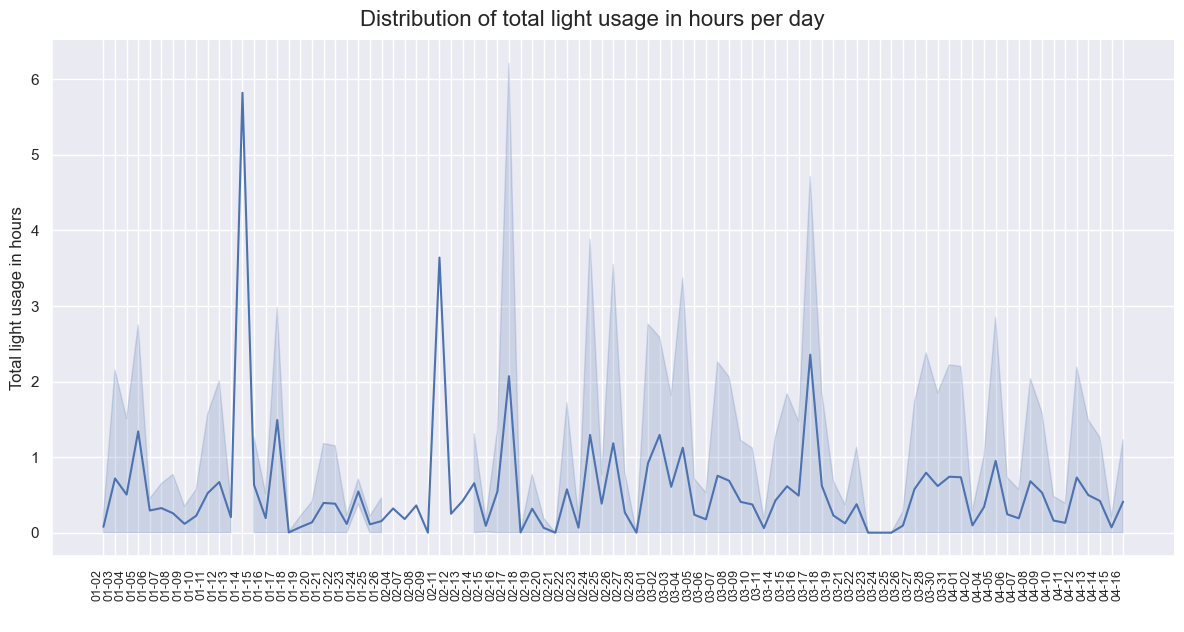

In [62]:
# plotting the mean and the 95% confidence interval around the mean
plot = sb.relplot(data=total_light_long, x='date', y='total_light', height=6, aspect=2, kind='line');
plt.xticks(rotation=90, ha='right', fontsize=9);

# Set title and axis labels
plot.fig.suptitle('Distribution of total light usage in hours per day', fontsize=16, x=0.5, y=1.02);
plt.xlabel(' ');
plt.ylabel('Total light usage in hours');

## Remarks on the plot

The plot depicts the distribution of the total light usage in hours per day in the living room. It also includes the 95% confidence intervals.
It is evident that there are fluctuations in the light usage throughout the days. There is no particular pattern that is followed and that can be observed.
However, we can indeed see that the maximum of total hours is reached on the 15th of January (01-15) with approximately 6 hours of light usage in the living room.
Starting from January and as the days and months go by, we would expect that longer daylight hours might result in less reliance on artificial lighting, potentially leading to shorter durations of light usage in the living room during those periods. Yet, no such trend is present.

## Tables

In [63]:
total_light_long[total_light_long.total_light!=0].describe()

,total_light
count,92.000000
mean,1.298587
std,1.265124
min,0.010000
25%,0.357500
50%,0.910000
75%,1.842500
max,6.210000


In [64]:
total_light_long[total_light_long.total_light!=0].groupby("device").describe()

total_light                                                       
               count      mean       std   min     25%    50%     75%   max
device                                                                     
TV              32.0  1.399063  1.511067  0.17  0.3125  0.750  1.7925  6.21
ceiling          5.0  0.286000  0.243578  0.12  0.1300  0.220  0.2500  0.71
corner 3         5.0  1.634000  2.373695  0.27  0.3800  0.430  1.2700  5.82
sofa            50.0  1.302000  0.969725  0.01  0.4775  1.165  1.8575  3.88

## Remarks on the tables

The tables are a descriptive summary of the light usage in the living room. 
From the two tables, we can see that the maximum amount of hours that the light was on in one day is 6.2 hours and in particular the light nearby the TV was on for that time period. Therefore, we can conclude that the residents gather ofter around the TV. In contrast, the minimum was 0.01 hours, which is related to the light close to the living room's sofa. This implies that the residents make use of the sofa quite rarely. On average, the light was on in the living room for about 1.3 hours per day.

## Conclusions

After having performed the above analysis, we can conclude the following:
The lights in the living room are on for 1.3 hours on average per day. This does not depend on the length of the day and thus it is independent from the duration of daylight. One possible explanation for that is the fact that the available data are from only 4 months and in the particular months the length of the daylight doesn't deviate significantly. Conclusions would be more meaningful if broader data were available covering a whole year. In such a way, more robust insights would be derived. In general, such knowledge would be highly valuable, since it would help in managing light usage effectively, but also promote sustainable practices and contribute to a more energy-conscious and environmentally-friendly approach to daily life.